In [50]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer


# Main configs

In [51]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000
INCLUDE_DIRECTION = True

# Load the data the old way


In [52]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [53]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, include_direction = False , TrimAt= 15 ):
    if include_direction:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1)  for x in inp ][:15])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ][:15])

In [54]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [55]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S', include_direction=False):
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    print( len(y_data), len(cleans) )
    
    ret_x  = [ mapping_x(x, include_direction=include_direction) for x in ret_x ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y, ret_y_s

In [56]:
x= []
y= []

x_test = []
y_test = []
y_test_service= []

x_train = {}
y_train = {}

test_names = []

add_to_trainig = [0,2]

if loadFromMerged:
    print("in load from merged")
    with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_hub_segments_final.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/test/test_homes/final_upload/Merged_final_with_home/merged_pcap_segments_final.json'  ) as f:
        x_data = json.load(f)
        
#     with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
#         y_data = json.load(f)

#     with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
#         x_data = json.load(f)
  
    if len( y_data ) != len(x_data) :
        print( pick )
        
    
    x_train,y_train, y_train_service= clean_data( x_data, y_data, IgnoreEmpty , 
                                                 Mapping=Mapper, include_direction=INCLUDE_DIRECTION )
    
    #     continue
#     if loadFromIndexes:
#         print("load from indexes")
#         with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
#             index_info = json.load(f)


#         for i in index_info[FoldID]["test"]:
#             x_test[str(i)]=(x_data[str(i)] )
#             y_test[str(i)]=(y_data[str(i)] )

#         for i in index_info[FoldID]["train"]:
#             x_train[str(i)]=(  x_data[str(i)] )
#             y_train[str(i)]=(  y_data[str(i)] )
        
#         x_test_t,y_test_t= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
#         x_test.append(x_test_t)
#         y_test.append(y_test_t)
    #     else :
    print("loading from test files")
    test_files = sorted(glob.glob( '../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/home*.json' ))
    print( "found files : " , len(test_files) )
    for pick  in test_files:
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/', fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join('../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/', fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper, include_direction= INCLUDE_DIRECTION )

#         if test_files.index(pick) in add_to_trainig:
#             x_test_t,y_test_t, y_test_service_t= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper)
#             x_train.extend(x_test_t)
#             y_train.extend(y_test_t)
#             y_train_service.extend(y_test_service_t)


        x_test.append(t_x)
        y_test.append(t_y)
        y_test_service.append(t_z)
            
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in sorted(glob.glob( '../files/train/hub_segments/*.json' )):
        fname  = os.path.basename(pick)
        test_names.append( fname )
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True, include_direction=INCLUDE_DIRECTION )

        x.extend( t_x)
        y.extend(t_y)

x= np.array(x)
y= np.array(y)

# x_train = np.append( x_train, x_test[0] , axis=0)
# x_train = np.append( x_train, x_test[2] , axis=0)

# y_train = np.append( y_train, y_test[0] , axis=0)
# y_train = np.append( y_train, y_test[2] , axis=0)


len(x_train), len(y_test)

in load from merged
58958 57867
loading from test files
found files :  4
32069 32069
19968 19968
9109 9109
6404 6404


(57867, 4)

# Evaluate Mittigation Techniques

## Packet Padding

In [8]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

In [9]:
# days =[7,4,2,2]
# t_sum =0
# d_sum = 0
# import math
# for ii in range(len(x_test)):

#     p = x_test[ii]
#     for i in p : 
#         t_sum += math.ceil(np.sum(i) / 2000)
#         d_sum+= np.sum( i )
# total_fixed  =  t_sum* 2000 / 15

# print ( total_fixed , d_sum, d_sum-t_sum*2000)

## Packet Insertion

In [10]:
# days =[7,4,2,2]
# t_sum =0
# for ii in range(len(x_test)):
#     p = x_test[ii]
#     sizes = np.unique(np.concatenate(p), return_counts=True)
#     sums= 0 
#     for i in range(len(sizes[0])):
# #         print( "%d--> %d" % ( sizes[0][i], sizes[1][i] ) )
#         if  sizes[0][i] < 1000:
#             sums+= (1000-sizes[0][i] )* sizes[1][i]
#     t_sum +=(sums / days[ii] )/1000000 
#     print ( (sums / days[ii] )/1000000)
# print('--------')
# print(t_sum/4)    

# sets the classes 

In [57]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
# print([ (i , classes[i]) for i in range( len(classes) ) ])

service_classes = sorted(list(np.unique(  np.concatenate( y_train_service  ))))
[ (i , service_classes[i]) for i in range( len(service_classes) ) ]

[(0, 'acceleration'),
 (1, 'activity'),
 (2, 'battery'),
 (3, 'button'),
 (4, 'colorTemperature'),
 (5, 'contact'),
 (6, 'level'),
 (7, 'lock'),
 (8, 'motion'),
 (9, 'ping'),
 (10, 'status'),
 (11, 'switch'),
 (12, 'temperature'),
 (13, 'threeAxis'),
 (14, 'unknown'),
 (15, 'water')]

## Filter the records by service/event types

In [58]:
def is_clean_event( inp, return_clean= True  ):
    return is_clean(inp, return_clean=return_clean, to_keep=[ 'no_logs', 'lock-unlocked', 'on/off-XXX', 'raw-XXX', 'read_attr_-_raw-XXX' ] )
#     if return_clean:
#         return  'no_logs' not in inp and 'lock-unlocked' not in inp and 'on/off-XXX' not in inp and 'raw-XXX' not in inp and 'read_attr_-_raw-XXX' not in inp
#     else:
#         return  'lock-locked' in inp or 'lock-unlocked'  in inp or 'on/off-XXX' in inp or  'raw-XXX' in inp  or 'read_attr_-_raw-XXX' in inp 
     
def is_clean_service( inp, return_clean= True  ):
    return is_clean(inp, to_keep=['no_logs','unknown', 'read_attr_-_raw'], return_clean=return_clean )
    
#     if return_clean:
#         return  'no_logs' not in inp and 'unknown' not in inp and 'read_attr_-_raw' not in inp #and 'ping' not in inp 
#     else:
#         return  'no_logs' in inp or  'unknown' in inp  or 'read_attr_-_raw' in inp #or 'ping' in inp 

def is_clean(inp, to_keep=[], return_clean=True):
    ret = False 
    
    for x  in to_keep:
        if x in inp:
            ret = True
            
    if not return_clean:
        ret = not ret
        
    return ret
    

choose services to keep : 

In [59]:
services_to_keep = [ 'contact', 'lock', 'motion',"ping", 'switch','unknown'] 

find records which need change

In [60]:
train_indexes_to_change =  [ i for i in range(len(y_train)) if
              is_clean( y_train[i],to_keep=services_to_keep, return_clean=False) ] 

y_train = [ ['unknown'] if i in train_indexes_to_change else y_train[i] 
           for i in range(len(y_train)) ] 

for t_index in range(len(y_test)):
    test_indexes_to_change =  [ i for i in range(len(y_test[t_index])) if
                  is_clean( y_test[t_index][i],to_keep=services_to_keep, return_clean=False) ] 

    y_test[t_index] = [ ['unknown'] if i in test_indexes_to_change else y_test[t_index][i] 
               for i in range(len(y_test[t_index])) ] 

In [61]:
known_unknown_y_train = [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_train ]

known_unknown_y_test= [] 

for i in range(len(y_test)):
    
    known_unknown_y_test.append( [ [1,0] if (len(x) == 1 and "unknown" in x) else [0,1]   for x in y_test[i] ])


remove classes that are ignored from the services list 

In [62]:
classes = services_to_keep

In [63]:
# toKeep = [ i for i in range(len(y_train)) if is_clean_event( y_train[i]) ] if Mapper=='SE' else [ i for i in range(len(y_train)) if is_clean_service( y_train[i]) ]
# x_train= [ x_train[i] for i in toKeep ]
# y_train= [ y_train[i] for i in toKeep ]


In [64]:
# for j in range(len(x_test)):
#     toChange= [ i for i in range(len(y_test[j])) if is_clean_service( y_test[j][i], False) ]
#     y_test[j] = [ (y_test[j][i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test[j])) ]

In [65]:
# classes.remove('read_attr_-_raw-XXX')
# classes.remove('on/off-XXX')
# classes.remove('raw-XXX')
# classes.remove('lock-unlocked')
# classes.remove('lock-locked')


# classes.remove('read_attr_-_raw')
# classes.remove('on/off')
# classes.remove('raw')
# classes.remove('unknown')

# classes.remove('lock')
# # classes.remove('lock')


# classes.remove('switch-on')




## ===== end of unknown packet control=====

In [66]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,
                    classes=None, twoD= False, as_string=False ):
#  y data 
# """
# this functino is in charge of preprocessing the records , the sourc e json contains a lot of extra stuff, this function tailors
# the data and it fixes their lenghth
# """
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            if y in classes:
                temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / (np.amax( x_data_temp) + 0.000000000001)
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    if as_string:
        x_data_temp = [ ' '.join(list(map(str,x))) for x in x_data_temp ]
    
    return x_data_temp ,y_data_categorical , classes

In [67]:
x,y,_=pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=True, classes=classes)

In [68]:
np.amax(x), np.amin(x)

(0.9999999999999997, -0.6071871127633207)

# Model Evaluation Methods

In [69]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
#     F= 2.0*( prec* recall )/ (prec+recall)
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    return acc, recall, prec, F

def acc_match( true, pred ):
    """
    returns exact mathc accuracy
    """
 
    return (len( [ x  for x  in  [np.sum(np.abs( true[i]- pred[i] )) for i in range(len(true))] if x  == 0]))*1.0 / len(true)


# def acc_none_zero ( true, pred ):
    

def acc_match_wierd( true, pred ):
    """
    returns exact mathc accuracy
    """
    level = 6 
    switch = 11
    threeAxis=13
    accel = 0 
    status=10
    contact=5
    
    counter  = 0 
    for i in range( len (true) ):
        if np.sum(np.abs( true[i]- pred[i] ))==0 :
            counter+=1
        else : 
            t_rec = np.array(list( pred[i]))
            
            if true[i][level]==1 and true[i][switch]==1 and t_rec[level]==1 :
                t_rec[switch]=1
            
            if true[i][threeAxis]==1 and true[i][accel]==1 and t_rec[threeAxis]==1:
                t_rec[accel] =1
            
            if true[i][status]==1 and true[i][contact]==1 and t_rec[status]==1:
                t_rec[contact]=1
#             print(t_rec , true[i])    
            if np.sum(np.abs( true[i]- t_rec ))==0 :
                counter+=1   
            
             
            
    
    return counter*1.0 / len(true)


def print_info(y_test, pred , classes , confidance=0.5 ):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s %22s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP/TN/FP/FN"))
    print( "------------------------------------------------------------------------" )
    ret  = [] 
    ret_description = ["Class","Accuracy", "Recall","Precision","F Score" , "Count", "TP","TN","FP","FN"]
    for index in range(len(classes)):
        tp = conf[index][1][1]
        tn = conf[index][0][0]
        fp = conf[index][0][1] 
        fn = conf[index][1][0]
        item = (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index],
                  tp ,
                tn ,
                fp ,
                fn)
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %  item )
        ret.append(item)
        
    n_zeros_true = len([ x  for x  in  [np.sum(np.abs( y_test[i] )) for i in range(len(y_test))] if x  == 0]  )
    n_zeros_pred = len([ x  for x  in  [np.sum(np.abs( pred[i] )) for i in range(len(pred))] if x  == 0]  )
    
    accs = np.nan_to_num(accs)
    
    print ("------------------------------------------------------------------------")
    print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d %5d/%5d/%5d/%5d"  %
             ("AVERAGES",
              np.average( accs, axis=0)[0],
              np.average( accs, axis=0)[1],
              np.average( accs, axis=0)[2],
              np.average( accs, axis=0)[3],
              len(y_test),
                  0 ,
                0,
                0 ,
                0 ))
    
    print ( "Exact Match ACC : %.5f " % acc_match( y_test, pred )  )
#     print ( "Wierd Exact Match ACC : %.5f" % acc_wierd)
    print ( "Total Records : %d " % len(y_test)  )
    print ( "Total ZXeros in True : %d (%.3f)%%" % (n_zeros_true ,  n_zeros_true * 1.0/ len(y_test)  ))
    print ( "Total ZXeros in Test : %d (%.3f)%%" % (n_zeros_pred ,  n_zeros_pred * 1.0/ len(y_test)  ) )
    print ('=============================================================================')
    
    return ret, ret_description
    

In [70]:


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def make_readable_results ( inp , classes , conffidance=True):
    ret = [] 
    inp =inp.astype(int)
    for xx in range(len(inp)) :
        u = inp[xx]
        temp = []
        for j in range(len(u)) : 
            if u[j] >0:
                temp.append(classes[j])
        ret.append(temp)
    return ret


def makeReadable( model , data, gt, path , classes, x, confidance=0.5):
    #collect across multi models
    from keras.models import load_model
    x=[]
    for i in range(0,16):
        model=load_model('number'+str(i)+'.h5',custom_objects={'f1_perRow':f1_perRow,'f1_perClass':f1_perClass,'f1_loss_perRow':f1_loss_perRow,'f1_loss_perClass':f1_loss_perClass})
        x.append(model.predict(data))
    x=np.array(x)
    x=np.transpose(x)
    x=np.squeeze(x)
    print(x.shape)
        
        
    pred_temp  = x
    #pred_temp = model.predict(data)
    print_info(gt, x, classes , confidance=confidance)
#     print( len(classes ), len( pred_temp[0] ) )
#     xcc= make_readable_results(pred_temp , classes)
#     y_gt = make_readable_results( gt, classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] =  { 'seq': str(data[pick]),
#                                'pred': xcc[pick],
#                                 'true':y_gt[pick]
#                                }   

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)


# def makeReadable( model , data, gt, path , classes, confidance=0.7, x):
#     pred_temp = model.predict( data)
#     print_info(gt, pred_temp, classes , confidance=confidance)
#     xcc= make_readable_results( pred_temp , classes )
#     temp_dic = {} 
#     for pick in range(len(xcc)): 
#         temp_dic[ pick +1 ] = xcc[pick]  

#     with open(path , 'w') as f:
#         json.dump(temp_dic , f, indent=4)

In [71]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import plot_tree
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

get the data and preprocess train and test portions

In [72]:
dim_size= 20
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes, as_string=True) for i in range(len(x_test)) ] 

vectorize the X vars

In [73]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 5))
x_random_forest_train = vectorizer.fit_transform(x_random_forest_train)
for x in range(len(rf_tests)):
    rf_tests[x] = ( vectorizer.transform(rf_tests[x][0]),
                    rf_tests[x][1],
                    rf_tests[x][2]
                  )
    

# XGBoost 

In [74]:

xgb_known_unknown_separator_classifier = OneVsRestClassifier(XGBClassifier())

xgb_known_unknown_separator_classifier.fit(x_random_forest_train, np.array(known_unknown_y_train))

train_known_unknown_pred=xgb_known_unknown_separator_classifier.predict_proba(x_random_forest_train)


In [75]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=xgb_known_unknown_separator_classifier.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.962      0.990     0.961     0.975     23896 23649/ 7203/  970/  247
                         known     0.962      0.881     0.967     0.922      8173  7203/23649/  247/  970
------------------------------------------------------------------------
                      AVERAGES     0.962      0.935     0.964     0.949     32069     0/    0/    0/    0
Exact Match ACC : 0.96205 
Total Records : 32069 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 0 (0.000)%
==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
   

In [76]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [77]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_random_forest_train, np.array(y_random_forest_train))


OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

In [79]:
xg_boost_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    xg_boost_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       contact     0.999      0.577     0.938     0.714        78    45/31988/    3/   33
                          lock     0.999      0.500     0.318     0.389        14     7/32040/   15/    7
                        motion     0.969      0.118     0.798     0.206      1099   130/30937/   33/  969
                          ping     0.997      0.997     0.990     0.993      6975  6953/25025/   69/   22
                        switch     1.000      0.652     0.938     0.769        23    15/32045/    1/    8
                       unknown     0.964      0.993     0.961     0.977     24696 24529/ 6385/  988/  167
------------------------------------------------------------------------
                      AVERAGES     0.988    

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
`

In [31]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=xgb_known_unknown_separator_classifier.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.962      0.990     0.961     0.975     23896 23649/ 7203/  970/  247
                         known     0.962      0.881     0.967     0.922      8173  7203/23649/  247/  970
------------------------------------------------------------------------
                      AVERAGES     0.962      0.935     0.964     0.949     32069     0/    0/    0/    0
Exact Match ACC : 0.96205 
Total Records : 32069 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 0 (0.000)%
==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
   

separate known and unknowns 

In [32]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [33]:
xgb_classifier = OneVsRestClassifier(XGBClassifier())

xgb_classifier.fit(x_random_forest_train, np.array(y_random_forest_train))

# train_known_unknown_pred=xgb_classifier.predict_proba(x_random_forest_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

In [78]:
def add_unknowns_back(y_pred, original_y, indexes, classes):
    unknown = [1 if classes[i] == 'unknown' else
                        0  
                       for i in range(len(classes))]
    the_y = [unknown for i in range(len(original_y))]
    for i, v in enumerate(indexes):
#         print(v)
        the_y[v] = y_pred[i]
    return np.array(the_y)
            

with putting back teh unknowns

In [35]:
xg_boost_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    xg_boost_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       contact     0.999      0.577     0.938     0.714        78    45/31988/    3/   33
                          lock     0.999      0.500     0.318     0.389        14     7/32040/   15/    7
                        motion     0.969      0.118     0.798     0.206      1099   130/30937/   33/  969
                          ping     0.997      0.997     0.990     0.993      6975  6953/25025/   69/   22
                        switch     1.000      0.652     0.938     0.769        23    15/32045/    1/    8
                       unknown     0.964      0.993     0.961     0.977     24696 24529/ 6385/  988/  167
------------------------------------------------------------------------
                      AVERAGES     0.988    

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


with out putting back the unknowns : 

In [86]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= xgb_classifier.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.857     0.857     0.857         7     6/ 7453/    1/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 7461/    0/    0
                       contact     0.999      0.917     0.936     0.926        48    44/ 7410/    3/    4
                          lock     0.998      0.636     0.368     0.467        11     7/ 7438/   12/    4
                        motion     0.990      0.713     0.792     0.750       160   114/ 7271/   30/   46
                          ping     0.988      1.000     0.988     0.994      6975  6974/  398/   88/    1
                        switch     0.999      0.727     0.941     0.821        22    16/ 7438/    1/    6
                       unknown     0.974      0.847     0.964     0.902      105

# Random Forest 

## string encoding test

In [36]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=100, max_depth=400,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [37]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [118]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       unknown     0.968      0.994     0.964     0.979     23896 23759/ 7277/  896/  137
                         known     0.968      0.890     0.982     0.934      8173  7277/23759/  137/  896
------------------------------------------------------------------------
                      AVERAGES     0.968      0.942     0.973     0.956     32069     0/    0/    0/    0
Exact Match ACC : 0.96779 
Total Records : 32069 
Total ZXeros in True : 0 (0.000)%
Total ZXeros in Test : 0 (0.000)%
==================HOME Case : home_os_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
   

In [38]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(test_known_unknown_predicted)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2],
                            known_indexes
                           ))

In [39]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=400,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [40]:
rf_results = []
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    rf_pred = add_unknowns_back(rf_pred,rf_tests[i][1], rf_test_known[i][3] , classes)
    rf_results.append(print_info( rf_tests[i][1], rf_pred, classes, confidance=0.8))

==================HOME Case : home_muhammed_final.json =============
                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                       contact     0.997      0.628     0.485     0.547        78    49/31939/   52/   29
                          lock     0.999      0.714     0.333     0.455        14    10/32035/   20/    4
                        motion     0.969      0.136     0.753     0.230      1099   149/30921/   49/  950
                          ping     0.997      0.997     0.991     0.994      6975  6952/25028/   66/   23
                        switch     1.000      0.783     0.783     0.783        23    18/32041/    5/    5
                       unknown     0.963      0.992     0.962     0.976     24696 24487/ 6398/  975/  209
------------------------------------------------------------------------
                      AVERAGES     0.988    

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [113]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.857     1.000     0.923         7     6/ 7407/    0/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 7414/    0/    0
                       contact     0.998      0.966     0.848     0.903        58    56/ 7346/   10/    2
                          lock     0.995      1.000     0.224     0.367        11    11/ 7365/   38/    0
                        motion     0.989      0.840     0.817     0.828       244   205/ 7124/   46/   39
                          ping     0.992      1.000     0.992     0.996      6952  6951/  405/   57/    1
                        switch     0.999      0.957     0.880     0.917        23    22/ 7388/    3/    1
                       unknown     0.982      0.883     0.966     0.923       91

In [115]:
values, desc = print_info( rf_test_known[i][1], rf_pred, classes, confidance=0.8)

                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.992      0.259     1.000     0.412        27     7/ 2476/    0/   20
              colorTemperature     1.000      1.000     1.000     1.000         1     1/ 2502/    0/    0
                       contact     0.994      0.842     1.000     0.914       101    85/ 2402/    0/   16
                          lock     0.999        nan     0.000     0.000         0     0/ 2501/    2/    0
                        motion     0.987      0.727     0.690     0.708        55    40/ 2430/   18/   15
                          ping     0.995      1.000     0.995     0.997      2303  2303/  188/   12/    0
                        switch     0.998      0.714     0.833     0.769        14    10/ 2487/    2/    4
                       unknown     0.987      0.884     0.944     0.913       18

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


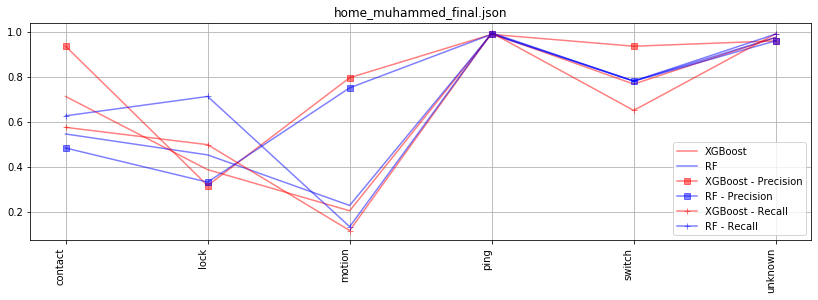

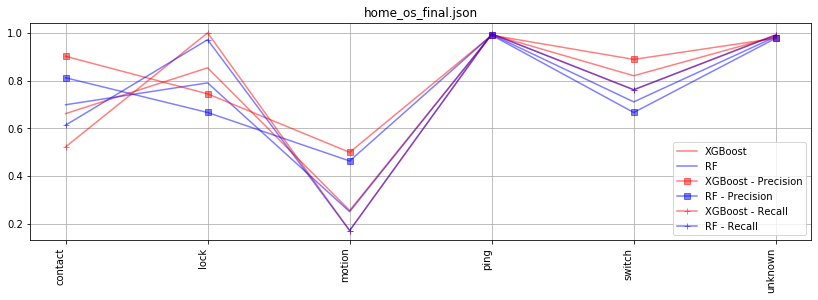

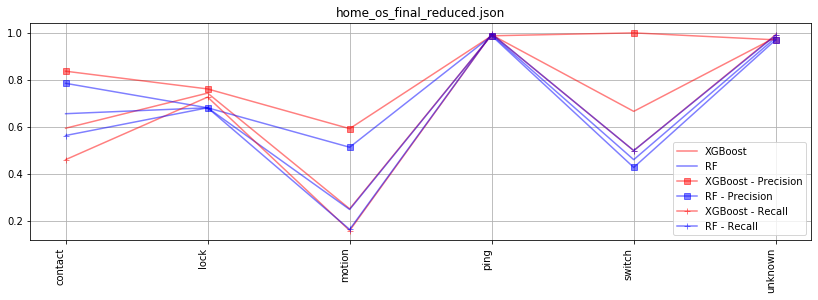

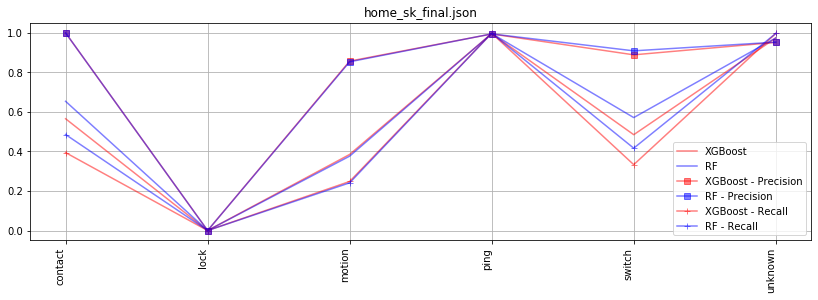

In [43]:
def fix_nan(inp):
    if np.isnan(inp):
        return 0
    else:
        return inp
desc = xg_boost_results[0][1]
index = 0 
for index in range(len(test_names)):
    plt.figure(figsize=(14,4))
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in xg_boost_results[index][0]],
        label="XGBoost",
         color="red" ,
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("F Score")]) for x in rf_results[index][0]],
        label="RF",
         color="blue" ,
             alpha=0.5
        )
    
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Precision",
         color="red" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Precision")]) for x in rf_results[index][0]],
        label="RF - Precision",
         color="blue" ,
             marker="s",
             alpha=0.5
        )
    plt.plot( [x[0] for x in xg_boost_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in xg_boost_results[index][0]],
        label="XGBoost - Recall",
         color="red" ,
             marker="+",
             alpha=0.5
        )
    plt.plot( [x[0] for x in rf_results[index][0]] , 
         [fix_nan(x[desc.index("Recall")]) for x in rf_results[index][0]],
        label="RF - Recall",
         color="blue" ,
             marker="+",
             alpha=0.5
        )

    # plt.plot( )
    plt.legend()
    plt.xticks(rotation=90, ha='right')
    plt.title(test_names[ index] )
    plt.grid()

ok ... bye bye now ... 

In [44]:
assert(False)

AssertionError: 

## Random Forest baseline calc

preproicess the data 

In [25]:
dim_size= 50
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
rf_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=True, normalize=False, classes=classes) for i in range(len(x_test)) ] 

first stage RF will learn if it is a known or unknown instance 

In [26]:
from sklearn.ensemble import RandomForestClassifier

knownity_rf =  RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
knownity_rf_results = knownity_rf.fit(x_random_forest_train, known_unknown_y_train)


In [27]:
train_known_unknown_pred=knownity_rf.predict(x_random_forest_train)

In [ ]:
test_known_unknown_predicted = []
for i in range(len(rf_tests)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred=knownity_rf.predict( rf_tests[i][0])
    test_known_unknown_predicted.append(rf_pred)
    print_info( np.array( known_unknown_y_test[i]), rf_pred, ["unknown","known"])

In [29]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_train_known = x_random_forest_train[known_indexes_train]
y_train_known = y_random_forest_train[known_indexes_train]

rf_test_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    rf_test_known.append(  (rf_tests[test_index][0][known_indexes], 
                            rf_tests[test_index][1][known_indexes],
                            rf_tests[test_index][2]))

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_train_known, y_train_known)


In [31]:
for i in range(len(rf_test_known)) :
    print( "==================HOME Case : %s =============" % test_names[ i] )
    rf_pred= clf.predict( rf_test_known[i][0])
    print_info( rf_test_known[i][1], rf_pred, classes)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.857     0.857     0.857         7     6/ 7391/    1/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 7399/    0/    0
                       contact     0.999      0.966     0.862     0.911        58    56/ 7332/    9/    2
                          lock     0.995      1.000     0.229     0.373        11    11/ 7351/   37/    0
                        motion     0.990      0.819     0.852     0.835       238   195/ 7127/   34/   43
                          ping     0.992      1.000     0.992     0.996      6952  6951/  390/   57/    1
                        switch     1.000      0.957     0.957     0.957        23    22/ 7375/    1/    1
                       unknown     0.983      0.897     0.961     0.928       90

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.999      0.000     0.000     0.000         1     0/ 2414/    1/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 2416/    0/    0
                       contact     0.997      0.942     0.925     0.933        52    49/ 2360/    4/    3
                          lock     0.992      0.923     0.400     0.558        13    12/ 2385/   18/    1
                        motion     0.978      0.654     0.500     0.567        52    34/ 2330/   34/   18
                          ping     0.990      1.000     0.989     0.994      2222  2222/  169/   25/    0
                        switch     0.998      1.000     0.375     0.545         3     3/ 2408/    5/    0
                       unknown     0.971      0.781     0.966     0.864       28

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


# CNN

In [29]:
# create the model
dim_size =20
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes, as_string=True)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes, as_string=True)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes) for i in range(len(x_test)) ] 



In [32]:
 x_random_forest_train[0].shape

(1, 18156)

In [33]:
type(x_lstm_prossed_train)

list

In [30]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

# x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
                            lstm_tests[test_index][1][known_indexes],
                            lstm_tests[test_index][2]))

In [31]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_random_forest_train,axis=1)
# x_lstm_prossed_train2 =x_random_forest_train


# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_train_known.toarray().reshape((x_train_known.shape[0],x_train_known.shape[1],1))

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [32]:
for tt  in range( len(rf_test_known) ):
    rf_test_known[tt]= (rf_test_known[tt][0].toarray().reshape(rf_test_known[tt][0].shape[0],
                                                     rf_test_known[tt][0].shape[1],
                                                     1) ,
                           rf_test_known[tt][1],
                           rf_test_known[tt][1] )

In [36]:
x_random_forest_train.shape, x_lstm_prossed_train22.shape

NameError: name 'x_lstm_prossed_train22' is not defined

In [33]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

W0116 16:50:07.171025 139730469132096 deprecation_wrapper.py:119] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [34]:
x_lstm_prossed_train2[0].shape[1]

1

In [35]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )

out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)

dout_1  = Dropout(0.2)(out)
# flt_1   = Flatten()(dout_1)
dense_1 = Dense(32, activation='relu')(dout_1)
# dout_3  = Dropout(0.2)(dense_1)
flt_1   = Flatten()(dense_1)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(flt_1)


model2 = Model(inputs=[inputs], outputs=[out_put_final])


losses = {
#     "service_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "Event_output": 30.0 ,
    "Event_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=70, batch_size=100, shuffle=True)

W0116 16:50:07.427331 139730469132096 deprecation_wrapper.py:119] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0116 16:50:07.432710 139730469132096 deprecation_wrapper.py:119] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0116 16:50:07.515601 139730469132096 deprecation_wrapper.py:119] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0116 16:50:07.536514 139730469132096 deprecation.py:506] From /home/omid/.conda/envs/iot/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18156, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18156, 128)        512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 18156, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 18156, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18156, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18156, 64)         24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 18156, 64)         0         
__________

In [36]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=50, batch_size=110, shuffle=True)

Epoch 1/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8535 - f1_perRow: 0.8794 - f1_perClass: 0.9847 - acc: 0.9582
Epoch 2/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8505 - f1_perRow: 0.8744 - f1_perClass: 0.9843 - acc: 0.9596
Epoch 3/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8479 - f1_perRow: 0.8768 - f1_perClass: 0.9862 - acc: 0.9597
Epoch 4/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8458 - f1_perRow: 0.8826 - f1_perClass: 0.9852 - acc: 0.9614
Epoch 5/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8486 - f1_perRow: 0.8732 - f1_perClass: 0.9858 - acc: 0.9576
Epoch 6/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8511 - f1_perRow: 0.8801 - f1_perClass: 0.9864 - acc: 0.9594
Epoch 7/50
24430/24430 [==============================] - 76s 3ms/step - loss: 1.8493 - f1_perRow: 0.8809 - f1_perClass: 0.9868 - acc: 0.9609
Epoch 

In [116]:
x_lstm_prossed_train2.shape

(57867, 18156)

In [45]:
K.clear_session()

In [43]:
lstm_tests_known[0][0][0]

array([270,  99, 403, 404,  99,  99, 270,  99, 403, 404,  99,  99, 270,
        99, 403, 404,  99,  99,   0,   0])

In [69]:
def describe_output(classes, instance):
    ret = [] 
    for x in range(len(instance)):
        if instance[x] > 0.6:
            ret.append(classes[x])
    return ret
def save_resutls(inp, y, y_hat, classes,the_name):
    items = [] 
    for i in range(len(inp)):
#         print(describe_output(classes, y[i]))
        items.append({'inp': str(list(inp[i])),
                     'true': list(describe_output(classes, y[i])),
                     'pred': list(describe_output(classes, y_hat[i]))
                     })
#         print(items[-1])
#         return
    with open('cnn_for_karthika_'+the_name +'.json', 'w') as outfile:
        json.dump(items, outfile)

In [66]:
describe_output(['a','b'],[1,0])

['a']

In [70]:
lstm_pred = []
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
    save_resutls( lstm_tests_known[i][0], rf_test_known[i][1], lstm_pred,  classes, test_names[i] )
#     break 
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.5)

==================HOME Case : home_muhammed_final.json =============
['switch']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping

['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['unknown']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'u

['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
[

['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['pin

['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping', 'unknown']
['motion']
['unknown']
['ping']
['motion']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['motion']
['ping']
['ping']
['ping']
['ping']
['ping']
['motion']
['ping']
['ping']
['motion']
['ping']
['unknown']
['ping', 'unknown']
['motion']
['ping']
['motion']
['ping', 'unknown']
['motion']
['ping']
['ping']
['ping']
['motion']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping', 'unk

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.857     1.000     0.923         7     6/ 7398/    0/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 7405/    0/    0
                       contact     0.998      0.966     0.800     0.875        58    56/ 7333/   14/    2
                          lock     0.995      0.909     0.208     0.339        11    10/ 7356/   38/    1
                        motion     0.988      0.925     0.755     0.831       240   222/ 7093/   72/   18
                          ping     0.992      1.000     0.992     0.996      6952  6952/  394/   59/    0
                        switch     1.000      0.913     1.000     0.955        23    21/ 7382/    0/    2
                       unknown     0.983      0.915     0.944     0.930       90

['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['contact']
['unknown']
['unknown']
['unknown']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['contact']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
[

['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']

['ping']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['switch']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['motion']
['ping', 'unknown']
['ping']
['ping']
['motion']
['ping']
['ping', 'unknown']
['ping']
['ping', 'unknown']
['ping']
['unknown']
['ping']
['pi

                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.999      0.429     1.000     0.600         7     3/ 5234/    0/    4
              colorTemperature     1.000      1.000     1.000     1.000         5     5/ 5236/    0/    0
                       contact     0.995      0.899     0.899     0.899       119   107/ 5110/   12/   12
                          lock     0.990      0.824     0.389     0.528        34    28/ 5163/   44/    6
                        motion     0.981      0.777     0.513     0.618       103    80/ 5062/   76/   23
                          ping     0.991      0.999     0.992     0.995      4817  4810/  385/   39/    7
                        switch     0.999      0.875     0.778     0.824        16    14/ 5221/    4/    2
                       unknown     0.969      0.781     0.945     0.855       61

['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping', 'unknown']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['p

                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     1.000      0.000       nan     0.000         1     0/ 2410/    0/    1
              colorTemperature     1.000        nan       nan       nan         0     0/ 2411/    0/    0
                       contact     0.995      0.935     0.843     0.887        46    43/ 2357/    8/    3
                          lock     0.991      0.800     0.387     0.522        15    12/ 2377/   19/    3
                        motion     0.981      0.774     0.554     0.646        53    41/ 2325/   33/   12
                          ping     0.988      0.998     0.989     0.994      2224  2220/  163/   24/    4
                        switch     1.000      1.000     0.750     0.857         3     3/ 2407/    1/    0
                       unknown     0.969      0.787     0.942     0.858       28

['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['contact']
['contact']
['ping']
['contact', 'motion']
['contact']
['ping']
['ping']
['contact']
['contact']
['contact']
['contact']
['ping']
['ping']
['ping']
['contact', 'motion']
['ping']
['contact']
['contact']
['contact']
['motion']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping', 'unknown']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['ping']
['contact']
['contact', 'motion']
['contact']
['motion']
['ping']
['ping']
['contact']
['contact']
['ping']
['ping']
['ping']


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.994      0.348     0.889     0.500        23     8/ 2471/    1/   15
              colorTemperature     1.000      1.000     1.000     1.000         1     1/ 2494/    0/    0
                       contact     0.996      0.911     0.979     0.944       101    92/ 2392/    2/    9
                          lock     0.999        nan     0.000     0.000         0     0/ 2493/    2/    0
                        motion     0.987      0.811     0.652     0.723        53    43/ 2419/   23/   10
                          ping     0.994      0.997     0.996     0.997      2303  2297/  182/   10/    6
                        switch     0.996      0.538     0.583     0.560        13     7/ 2477/    5/    6
                       unknown     0.986      0.914     0.895     0.905       18

In [68]:
save_resutls( lstm_tests_known[0][0], rf_test_known[0][1], lstm_pred, classes, test_names[0] )

['switch']
{'inp': '[270, 99, 403, 404, 99, 99, 270, 99, 403, 404, 99, 99, 270, 99, 403, 404, 99, 99, 0, 0]', 'true': ['switch'], 'pred': ['switch']}


In [67]:
describe_output(classes, rf_test_known[0][1][0])

['switch']

## LSTM


In [77]:
inputs  = Input(  (x_lstm_prossed_train2[0].shape[0]  ,1) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(64,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(30 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(64, activation='relu')  (lstm_1)
lstm_1 =  Dense(32, activation='relu')(bi_d_1)
lstm_2 = Dense(16, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(16, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
# lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

# bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
# lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
# lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

# dout_1  = Dropout(0.1)(lstm_raw_2)
# flt_1   = Flatten()(dout_1)
# dense_1 = Dense(128, activation='relu')(flt_1)
# dout_3  = Dropout(0.2)(dense_1)





# out = Conv1D(128,3,padding='same')(inputs)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)
# # out = Flatten()(out)
# # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


# out = Conv1D(128,3,padding='same')(out)
# out = BatchNormalization()(out)
# out = Activation('relu')(out)
# out = Dropout(0.2)(out)
# out = Conv1D(128,3,padding='same')(out)


# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

# fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
# out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')
# out_new = concatenate( [dout_2] , name='mergerguy')

# dens_out_1 = Dense( 128, activation='relu' )(out_new)
# dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
# dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dout_2)

# toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
# toService_1 = Dense( 130, name="to_service2" )(toService_1)

# service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[out_put_final])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "Event_output": f1_loss_perRow ,
    "Event_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "Event_output": 30.0 ,
    "Event_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=80, batch_size=70, shuffle=True, callbacks=callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18156, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18156, 128)        512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 18156, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 18156, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18156, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18156, 64)         24640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 18156, 30)         11400     
__________

KeyboardInterrupt: 

In [ ]:
K.clear_session()

In [78]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( rf_test_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( rf_test_known[i][1], lstm_pred, classes , confidance=0.7)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.001      1.000     0.001     0.002         7     7/    0/ 7398/    0
              colorTemperature     0.000        nan     0.000     0.000         0     0/    0/ 7405/    0
                       contact     0.008      1.000     0.008     0.016        58    58/    0/ 7347/    0
                          lock     0.001      1.000     0.001     0.003        11    11/    0/ 7394/    0
                        motion     0.032      1.000     0.032     0.063       240   240/    0/ 7165/    0
                          ping     0.939      1.000     0.939     0.968      6952  6952/    0/  453/    0
                        switch     0.003      1.000     0.003     0.006        23    23/    0/ 7382/    0
                       unknown     0.123      1.000     0.123     0.219       90

KeyboardInterrupt: 

# LSTM 

In [90]:
# create the model
dim_size =15
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
_, y_s_lstm_processed_train ,_ =  pre_process_raw( x_train, y_train_service , dim_size, zero_pad=False, normalize=False,classes=service_classes)
# x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)
lstm_tests  = [ pre_process_raw( x_test[i], y_test[i] , dim_size, zero_pad=False, normalize=False, classes=classes) for i in range(len(x_test)) ] 
lstm_tests_services  = [ pre_process_raw( x_test[i], y_test_service[i] , dim_size, zero_pad=False, normalize=True, classes=service_classes) for i in range(len(x_test)) ] 



In [91]:
known_indexes_train  = [ i for i in range(len(train_known_unknown_pred)) if train_known_unknown_pred[i][1] ==1 ]

x_lstm_prossed_train = x_lstm_prossed_train[known_indexes_train]
y_lstm_prossed_train = y_lstm_prossed_train[known_indexes_train]

lstm_tests_known = [] 

for test_index in range(len(rf_tests)):
    known_indexes= [ i for i in range(len(test_known_unknown_predicted[test_index])) if test_known_unknown_predicted[test_index][i][1] ==1 ]
    
    lstm_tests_known.append(  (lstm_tests[test_index][0][known_indexes], 
                            lstm_tests[test_index][1][known_indexes],
                            lstm_tests[test_index][2]))

In [92]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

for tt  in range( len(lstm_tests_known) ):
    lstm_tests_known[tt]= (lstm_tests_known[tt][0].reshape(len(lstm_tests_known[tt][0]),dim_size,1) ,
                           lstm_tests_known[tt][1],
                           lstm_tests_services[tt][1] )
# x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [93]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE
model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

In [40]:
inputs  = Input( ( dim_size,1 ) )


out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)





# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

 
weights = [
1.0/(57.0 / len(y_train)),
1.0/(19.0 / len(y_train)),
1.0/(7.0 / len(y_train)),
1.0/(14.0 / len(y_train)),
1.0/(6.0 / len(y_train)),
1.0/(176.0 / len(y_train)),
1.0/(27.0 / len(y_train)),
1.0/(35.0 / len(y_train)),
1.0/(371.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
1.0/(4842.0 / len(y_train)),
1.0/(119.0 / len(y_train)),
1.0/(21.0 / len(y_train)),
1.0/(1168.0 / len(y_train)),
1.0/(63.0 / len(y_train)),
1.0/(13305.0 / len(y_train)),
1.0/(11111.0 / len(y_train)),
]
    


# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15, 1)        0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 15, 128)      512         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 15, 128)      512         conv1d_19[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 15, 128)      0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv1d_17 

Epoch 1/100
24427/24427 [==============================] - 5s 222us/step - loss: 41.0789 - f1_perRow: 0.1408 - f1_perClass: 0.2438 - acc: 0.4151
Epoch 2/100
24427/24427 [==============================] - 1s 37us/step - loss: 23.1859 - f1_perRow: 0.2311 - f1_perClass: 0.5514 - acc: 0.8173
Epoch 3/100
24427/24427 [==============================] - 1s 36us/step - loss: 12.3100 - f1_perRow: 0.3912 - f1_perClass: 0.8365 - acc: 0.8173
Epoch 4/100
24427/24427 [==============================] - 1s 36us/step - loss: 10.8088 - f1_perRow: 0.4712 - f1_perClass: 0.8315 - acc: 0.8173
Epoch 5/100
24427/24427 [==============================] - 1s 35us/step - loss: 9.2991 - f1_perRow: 0.5437 - f1_perClass: 0.8641 - acc: 0.8173
Epoch 6/100
24427/24427 [==============================] - 1s 35us/step - loss: 8.2308 - f1_perRow: 0.5894 - f1_perClass: 0.8674 - acc: 0.8173
Epoch 7/100
24427/24427 [==============================] - 1s 36us/step - loss: 7.7272 - f1_perRow: 0.6167 - f1_perClass: 0.8756 - acc: 0

In [43]:
# print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)



Epoch 1/200
24427/24427 [==============================] - 1s 37us/step - loss: 4.7279 - f1_perRow: 0.8576 - f1_perClass: 0.9273 - acc: 0.8188
Epoch 2/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7058 - f1_perRow: 0.8533 - f1_perClass: 0.9268 - acc: 0.8184
Epoch 3/200
24427/24427 [==============================] - 1s 35us/step - loss: 4.7014 - f1_perRow: 0.8500 - f1_perClass: 0.9268 - acc: 0.8191
Epoch 4/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7062 - f1_perRow: 0.8528 - f1_perClass: 0.9272 - acc: 0.8193
Epoch 5/200
24427/24427 [==============================] - 1s 35us/step - loss: 4.7033 - f1_perRow: 0.8542 - f1_perClass: 0.9271 - acc: 0.8195
Epoch 6/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.6969 - f1_perRow: 0.8547 - f1_perClass: 0.9272 - acc: 0.8192
Epoch 7/200
24427/24427 [==============================] - 1s 36us/step - loss: 4.7076 - f1_perRow: 0.8545 - f1_perClass: 0.9270 - acc: 0.8194

24427/24427 [==============================] - 1s 36us/step - loss: 3.2604 - f1_perRow: 0.8309 - f1_perClass: 0.9579 - acc: 0.9231
Epoch 114/200
24427/24427 [==============================] - 1s 36us/step - loss: 3.2515 - f1_perRow: 0.8326 - f1_perClass: 0.9587 - acc: 0.9236
Epoch 115/200
24427/24427 [==============================] - 1s 38us/step - loss: 3.2036 - f1_perRow: 0.8373 - f1_perClass: 0.9597 - acc: 0.9257
Epoch 116/200
24427/24427 [==============================] - 1s 38us/step - loss: 3.1905 - f1_perRow: 0.8329 - f1_perClass: 0.9589 - acc: 0.9266
Epoch 117/200
24427/24427 [==============================] - 1s 36us/step - loss: 3.1778 - f1_perRow: 0.8311 - f1_perClass: 0.9593 - acc: 0.9264
Epoch 118/200
24427/24427 [==============================] - 1s 40us/step - loss: 3.1659 - f1_perRow: 0.8299 - f1_perClass: 0.9587 - acc: 0.9300
Epoch 119/200
24427/24427 [==============================] - 1s 38us/step - loss: 3.1622 - f1_perRow: 0.8326 - f1_perClass: 0.9600 - acc: 0.9342

In [47]:
for i in range(len(lstm_tests_known)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests_known[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests_known[i][1], lstm_pred, classes , confidance=0.3)

==================HOME Case : home_muhammed_final.json =============


/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


                         Class  Accuracy     Recall  Precision   F Score    Count            TP/TN/FP/FN
------------------------------------------------------------------------
                        button     0.981      0.714     0.035     0.068         7     5/ 7256/  136/    2
              colorTemperature     1.000        nan       nan       nan         0     0/ 7399/    0/    0
                       contact     0.997      0.983     0.704     0.820        58    57/ 7317/   24/    1
                          lock     0.995      0.909     0.217     0.351        11    10/ 7352/   36/    1
                        motion     0.987      0.815     0.792     0.803       238   194/ 7110/   51/   44
                          ping     0.991      1.000     0.991     0.995      6952  6950/  383/   64/    2
                        switch     0.999      0.913     0.840     0.875        23    21/ 7372/    4/    2
                       unknown     0.987      0.935     0.955     0.945       90

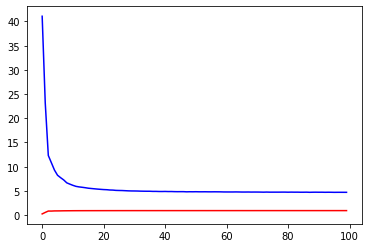

In [42]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)

In [ ]:
plt.plot(hist2.history['f1_perClass'], c='red')
plt.plot(hist2.history['loss'], c='blue')

In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_1 =Dense(128, activation='relu')  (lstm_1)
lstm_1 =  Dense(128, activation='relu')(bi_d_1)
lstm_2 = Dense(128, activation='relu')(lstm_1)



# td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
# dout_1  = Dropout(0.1)(td_1)
dout_1  = Dropout(0.1)(lstm_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_2  = Dropout(0.2)(dense_1)







dens_out_3 = Dense( 128, activation='relu' )(dout_2)


# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


#model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=1000, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )






out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)


dens_out_3 = Dense( 128, activation='relu' )(fl_out_cnn)

# fl2  = Flatten()(out_new)

out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
toService_1 = Dense( 130, name="to_service2" )(toService_1)

service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1)) 

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))



inputs  = Input( ( dim_size,1 ) )







# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
# lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

dout_1  = Dropout(0.1)(lstm_raw_2)
flt_1   = Flatten()(dout_1)
dense_1 = Dense(128, activation='relu')(flt_1)
dout_3  = Dropout(0.2)(dense_1)





out = Conv1D(128,3,padding='same')(inputs)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


out = Conv1D(128,3,padding='same')(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.2)(out)
out = Conv1D(128,3,padding='same')(out)
# out = Flatten()(out)
# out = MaxPooling1D(2,padding='same', name ='pooling')(out)



# fl_out_1 = Flatten()(dout_2)

fl_out_cnn = Flatten()(out)

# out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
out_new = concatenate( [ fl_out_cnn,dout_3] , name='mergerguy')

dens_out_1 = Dense( 128, activation='relu' )(out_new)
dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)



service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(dens_out_3)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)





In [ ]:
losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perClass ,
#     "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
#     "service_output": 20
}
 


model2.compile(loss=losses, loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=1e-6  ), metrics=[f1_perRow,f1_perClass,'acc'])


In [ ]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2



inputs  = Input( ( dim_size,1 ) )



# bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
lstm_1 =  LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(inputs)
lstm_2 = LSTM(32 ,  recurrent_dropout=0.3, return_sequences=True)(lstm_1)

lstm_2=Flatten()(lstm_2)
lstm_2 = Dense(256, activation='relu')(lstm_2)




service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(lstm_2)



model2 = Model(inputs=[inputs], outputs=[service_output])




# model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
# model2.add( LSTM(60 ,  recurrent_dropout=0.04, return_sequences=True))
# model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# # model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
# model2.add(TimeDistributed(Dense(256, activation='relu')))
# model2.add(Dropout(0.1))
# model2.add(Flatten())
# model2.add(Dense(128, activation='relu'))
# model2.add(Dropout(0.2))
# model2.add(Dense(len(classes), activation='sigmoid'))

# model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])



losses = {
#     "service_output": f1_loss_perClass ,
    "service_output": f1_loss_perRow ,
    "service_output": "categorical_crossentropy",
}
lossWeights = {#"service_output": 20,
               "service_output": 30.0 ,
    "service_output": 20}
 


model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
# model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

print(model2.summary())

hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, callbacks=callbacks_list)



In [ ]:
#split model
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


import tensorflow as tf

def f1_perRow(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def f1_perClass(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss_perClass(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

def f1_loss_perRow(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return (1 - K.mean(f1))**2

#splitting data
X=x_lstm_prossed_train2
y=y_lstm_prossed_train
a,b,c,d,e,f,g,h,ii,jj,k,l,m,n,o,p=[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
print(len(y_lstm_prossed_train[0]))
for i in range(0,len(y_lstm_prossed_train)):
    a.append(y_lstm_prossed_train[i][0])
    b.append(y_lstm_prossed_train[i][1])
    c.append(y_lstm_prossed_train[i][2])
    d.append(y_lstm_prossed_train[i][3])
    e.append(y_lstm_prossed_train[i][4])
    f.append(y_lstm_prossed_train[i][5])
    g.append(y_lstm_prossed_train[i][6])
    h.append(y_lstm_prossed_train[i][7])
    ii.append(y_lstm_prossed_train[i][8])
    jj.append(y_lstm_prossed_train[i][9])
    k.append(y_lstm_prossed_train[i][10])
    l.append(y_lstm_prossed_train[i][11])
    m.append(y_lstm_prossed_train[i][12])
    n.append(y_lstm_prossed_train[i][13])
    o.append(y_lstm_prossed_train[i][14])
    p.append(y_lstm_prossed_train[i][15])
    
zzzz=[]    
zzzz.append(np.array(a))
zzzz.append(np.array(b))
zzzz.append(np.array(c))
zzzz.append(np.array(d))
zzzz.append(np.array(e))
zzzz.append(np.array(f))
zzzz.append(np.array(g))
zzzz.append(np.array(h))
zzzz.append(np.array(ii))
zzzz.append(np.array(jj))
zzzz.append(np.array(k))
zzzz.append(np.array(l))
zzzz.append(np.array(m))
zzzz.append(np.array(n))
zzzz.append(np.array(o))
zzzz.append(np.array(p))


for i in range(0,16):
    
    
        
        
    


    inputs  = Input( ( dim_size,1 ) )


    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
    # lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_1 =  Dense(128, activation='relu')(bi_d_1)
    lstm_2 = Dense(128, activation='relu')(lstm_1)



    # td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
    # dout_1  = Dropout(0.1)(td_1)
    dout_1  = Dropout(0.1)(lstm_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_2  = Dropout(0.2)(dense_1)





    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
    # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
    lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

    dout_1  = Dropout(0.1)(lstm_raw_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_3  = Dropout(0.2)(dense_1)





    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)



    # fl_out_1 = Flatten()(dout_2)

    fl_out_cnn = Flatten()(out)

    # out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
    out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

    dens_out_1 = Dense( 128, activation='relu' )(out_new)
    dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
    dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

    # fl2  = Flatten()(out_new)

    out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

    toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
    toService_1 = Dense( 130, name="to_service2" )(toService_1)

    service_output = Dense(1, activation="sigmoid", name = 'service_output')(toService_1)


    losses = {
    #     "service_output": f1_loss_perClass ,
        "service_output": f1_loss_perRow ,
        "service_output": "binary_crossentropy",
    }
    lossWeights = {#"service_output": 20,
                   "service_output": 30.0 ,
        "service_output": 20}




    model2 = Model(inputs=[inputs], outputs=[service_output])
    model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
    # model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('IoTDownNet', monitor='loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    hist2 = model2.fit(x_lstm_prossed_train2, zzzz[i], epochs=200, batch_size=12500, shuffle=True, callbacks=callbacks_list)
    model2.save('number'+str(i)+'.h5')


In [ ]:
# model2.compile(loss=losses,loss_weights=lossWeights, optimizer=keras.optimizers.Adam(lr=5e-5  ), metrics=[f1_perRow,f1_perClass,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=16500, shuffle=True)


In [ ]:
model2.compile(loss=f1_loss, optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=[f1,'acc'])
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=7500, shuffle=True)

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=3500, shuffle=True)

In [ ]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

In [ ]:
plt.plot(hist2.history['loss'], c='red')
plt.plot(hist2.history['acc'], c='blue')

In [ ]:
plt.plot(hist2.history['loss'], c='red')
# plt.plot(hist2.history['acc'], c='blue')

In [ ]:
from keras.utils import plot_model
plot_model(model2, to_file='model.png')

In [ ]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [ ]:
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    makeReadable( classes=classes, confidance=0.5,data=lstm_tests[i][0],gt=lstm_tests[i][1],model=model2,path=test_names[i],x=lstm_tests[i][0])
    
#     lstm_pred= model2.predict( lstm_tests[i][0])
    


# ------------- do not go any further :) ------

In [ ]:
lstm_pred= model2.predict( lstm_tests[i][0])

In [ ]:
lstm_pred= model2.predict( lstm_tests[1][0])
lstm_pred__ = np.array(list(lstm_pred))

In [ ]:
lstm_pred__ = np.array(list(lstm_pred))
print_info( lstm_tests[1][1], lstm_pred__, classes , confidance=0.43)

In [ ]:
# for i in [1] :
for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.5)
    

In [ ]:
for i in [1] :
# for i in range(len(lstm_tests)) :
    print( "==================HOME Case : %s =============" % test_names[i])
    lstm_pred= model2.predict( lstm_tests[i][0])
    
#     print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.7)
    print_info( lstm_tests[i][1], lstm_pred, classes , confidance=0.992)
    



In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

In [ ]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

In [ ]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

In [ ]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

In [ ]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [ ]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

In [ ]:
pred[:10]

In [ ]:
print_info(y_lstm_prossed_test, pred, classes)

In [ ]:
pred[0]

In [ ]:
len( y_lstm_prossed_train[0] )

In [ ]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [ ]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

In [ ]:
[ x for x  in  pred if np.sum(x) > 1]

In [ ]:
len(y_lstm_prossed_test)

In [ ]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [ ]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

In [ ]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [ ]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)